# Tutorial Part-of-Speech tagging  Con Deep Learning (mb-09)

### En este tutorial, veremos cómo se puede mejorar el modelo Bi-LSTM, usando la tecnica de Dropout en la capa oculta, agregando las relaciones de un modelo preentrenado (SWBE) con la tecnica word2vec. 

## PARTE 1  -  Pre-Procesamiento
### Cargamos los Datos de pre-procesamiento de modelo base mb-00

In [1]:
# Asegurar reproducibilidad

import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)
IS_NEW = 0

### Descargamos el modelo Preentrenado SWBCE de one billion. 

In [2]:
#!conda install -c anaconda wget -y
if(IS_NEW == 1):
    import os
    Path_pc = "/home/deep-learning/postagging_deep_learning/vectors/"
    
    command = os.popen('wget http://cs.famaf.unc.edu.ar/~ccardellino/SBWCE/SBW-vectors-300-min5.txt.bz2 -P ' + Path_pc)
    print(command.read())
    print(command.close())
    
    command = os.popen('bzip2 -d ' + Path_pc + 'SBW-vectors-300-min5.txt.bz2')
    print(command.read())
    print(command.close())

In [ ]:
to_categoricals convierte secuencias de palabras a vectores one-hot

In [3]:
def to_categoricals(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)

    return np.array(cat_sequences)


MAX-LENGTH es el máximo de palabras por oración, cuando una oración tiene menos palabras se llenan los espacios vacíos con fin de etiqueta. Los npy son matrices de numpy de mejor acceso.

In [4]:
import pickle

MAX_LENGTH = 149

test_tags = []
with open("../vectors/test_tags.txt", "rb") as fp:
    test_tags = pickle.load(fp)
    
word2index = np.load('../vectors/word2index.npy',allow_pickle=True).item()
tag2index  = np.load('../vectors/tag2index.npy',allow_pickle=True).item()

train_sentences_X = np.load('../vectors/train_sentences_X.npy',allow_pickle=True)
eval_sentences_X  = np.load('../vectors/eval_sentences_X.npy',allow_pickle=True)
test_sentences_X  = np.load('../vectors/test_sentences_X.npy',allow_pickle=True)

train_tags_y = np.load('../vectors/train_tags_y.npy',allow_pickle=True)
eval_tags_y  = np.load('../vectors/eval_tags_y.npy',allow_pickle=True)
test_tags_y  = np.load('../vectors/test_tags_y.npy',allow_pickle=True)

cat_train_tags_y = to_categoricals(train_tags_y, len(tag2index))
cat_eval_tags_y  = to_categoricals(eval_tags_y, len(tag2index))
cat_test_tags_y  = to_categoricals(test_tags_y, len(tag2index))

print (len(word2index))
#print(word2index)
print (len(tag2index))
print(tag2index)

print(len(train_sentences_X))
#print(eval_sentences_X[0])
#print(test_sentences_X[0])
print(cat_train_tags_y[0])

24499
291
{'vasi3s0': 2, 'vssi3p0': 3, 'vmis2s0': 4, 'nccs000': 5, 'Fat': 6, 'ncms000': 7, 'np0000o': 8, 'vaip1s0': 9, 'aq0msp': 10, 'pp2cs00p': 11, 'vmp00sm': 12, 'pn0cp000': 13, 'pp3msa00': 14, 'sn.e-CD': 15, 'vsis3p0': 16, 'vsp00sm': 17, 'Faa': 18, 'vsic1s0': 19, 'vsip1p0': 20, 'dp3fs0': 21, 'nc00000': 22, 'nccp000': 23, 'pp3csd00': 24, 'vmic1s0': 25, 'pp1cs000': 26, 'aq0cs0': 27, 'sn-SUJ': 28, 'vmip1s0': 29, 'aq0fsp': 30, 'pp3cpa00': 31, 'pd0cp000': 32, 'pd0ms000': 33, 'vssi3s0': 34, 'dp3mp0': 35, 'pt000000': 36, 'rg': 37, 'vaip1p0': 38, 'da0ms0': 39, 'vmsi1s0': 40, 'pr0fs000': 41, 'vmii2p0': 42, 'dn0cs0': 43, 'np00000': 44, 'W': 45, 'sn.e.1n-SUJ': 46, 'vsip1s0': 47, 'vsii1p0': 48, 'pn0mp000': 49, 'di0cp0': 50, 'pd0ns000': 51, 'pd0fp000': 52, 'vmsp3p0': 53, 'vais3s0': 54, 'vmic1p0': 55, 'da0ns0': 56, 'vsip2s0': 57, 'dn0fp0': 58, 'aq0cp0': 59, 'p020s000': 60, 'pn0fp000': 61, 'pd0cs000': 62, 'vmsi3s0': 63, 'vmip1p0': 64, 'dp1mss': 65, 'vaip2p0': 66, 'vmsp3s0': 67, 'vmip3p0': 68, 'vsi

Esta es una forma de ver las 24500 palabras de ancora indexadas y únicas.


In [30]:
#for key,val in word2index.items():
#    print(key, "=>", val)

Aquí se indexan los vectores de SBWE

In [5]:
embeddings_index = {}
f = open('../vectors/SBW-vectors-300-min5.txt')
for a, line in enumerate(f):
    if a > 0:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(type(embeddings_index))
print(len(word2index))




Found 1000653 word vectors.
<class 'dict'>
24499


En esta parte se hace el emparejamiento de las 24500 palabras únicas de ancora con las  1000653 de palabras  vectorizadas de SBWE para generar la matriz de embedding con las 24500 palabras  de dimensión 300 como fue preentrenado el SBWE con word2vec. 

In [6]:
embedding_matrix = np.zeros((len(word2index) + 1, 300))
for t, (word, i) in enumerate(word2index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # las palabras que no se encuentren en el índice de inserción serán todos ceros.
        embedding_matrix[t] = embedding_vector

embedding_matrix.shape
#print(embedding_matrix[1])

(24500, 300)

## PARTE 2  -  Entrenamiento

In [7]:
## Funcion que permite forzar el uso de GPU cuando estan presentes

import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: GeForce GTX 1060 6GB, pci bus id: 0000:02:00.0, compute capability: 6.1



### Definimos el Modelo Base con el cual se procedera a desarrollar la fase de Entrenamiento

La fase de entrenamiento consiste del entranamiento de una red BLST de ida y vuelta. Como entrada de la red tenemos las oraciones en dimensiones de 149 donde van las oraciones del corpus SWBC que junto con la matriz de embedding de 24500 X 300 se convierten en el nivel de embedding, en últimas se comporta como una matriz tridimensional de 24500 X 149 X 300. 24500 oraciones del corpus SWBC, 149 que es la dimensión de las oraciones, la cual por cada oración se llena de marcadores donde no hay palabras. 300 son las características semánticas del tamaño de la ventana. La salida de este nivel de embedding es una matriz de 149 X 300 que sería la entrada de un BLSTM (red neuronal recurviva en doble dirección) esta es la red que aprende la secuenciación de las oraciones con sus respectivas etiquetas  contextualizando cada una de las posiciones de la matriz de 149 X 300 de iz a DER y viceversa. la salida de este entrenamiento es una matriz de 149 X 600. Luego viene la distribución de probabilidad que da como salida el número de etiquetas que son 291, una matriz de 149 X 291 para cada 24500 oraciones.  El drouput limpia los pesos que cambian en la retro propagación y mejoran el rendimiento.Finalmente vien la activación usando softwax para obtener la probailización de las etiquetas.

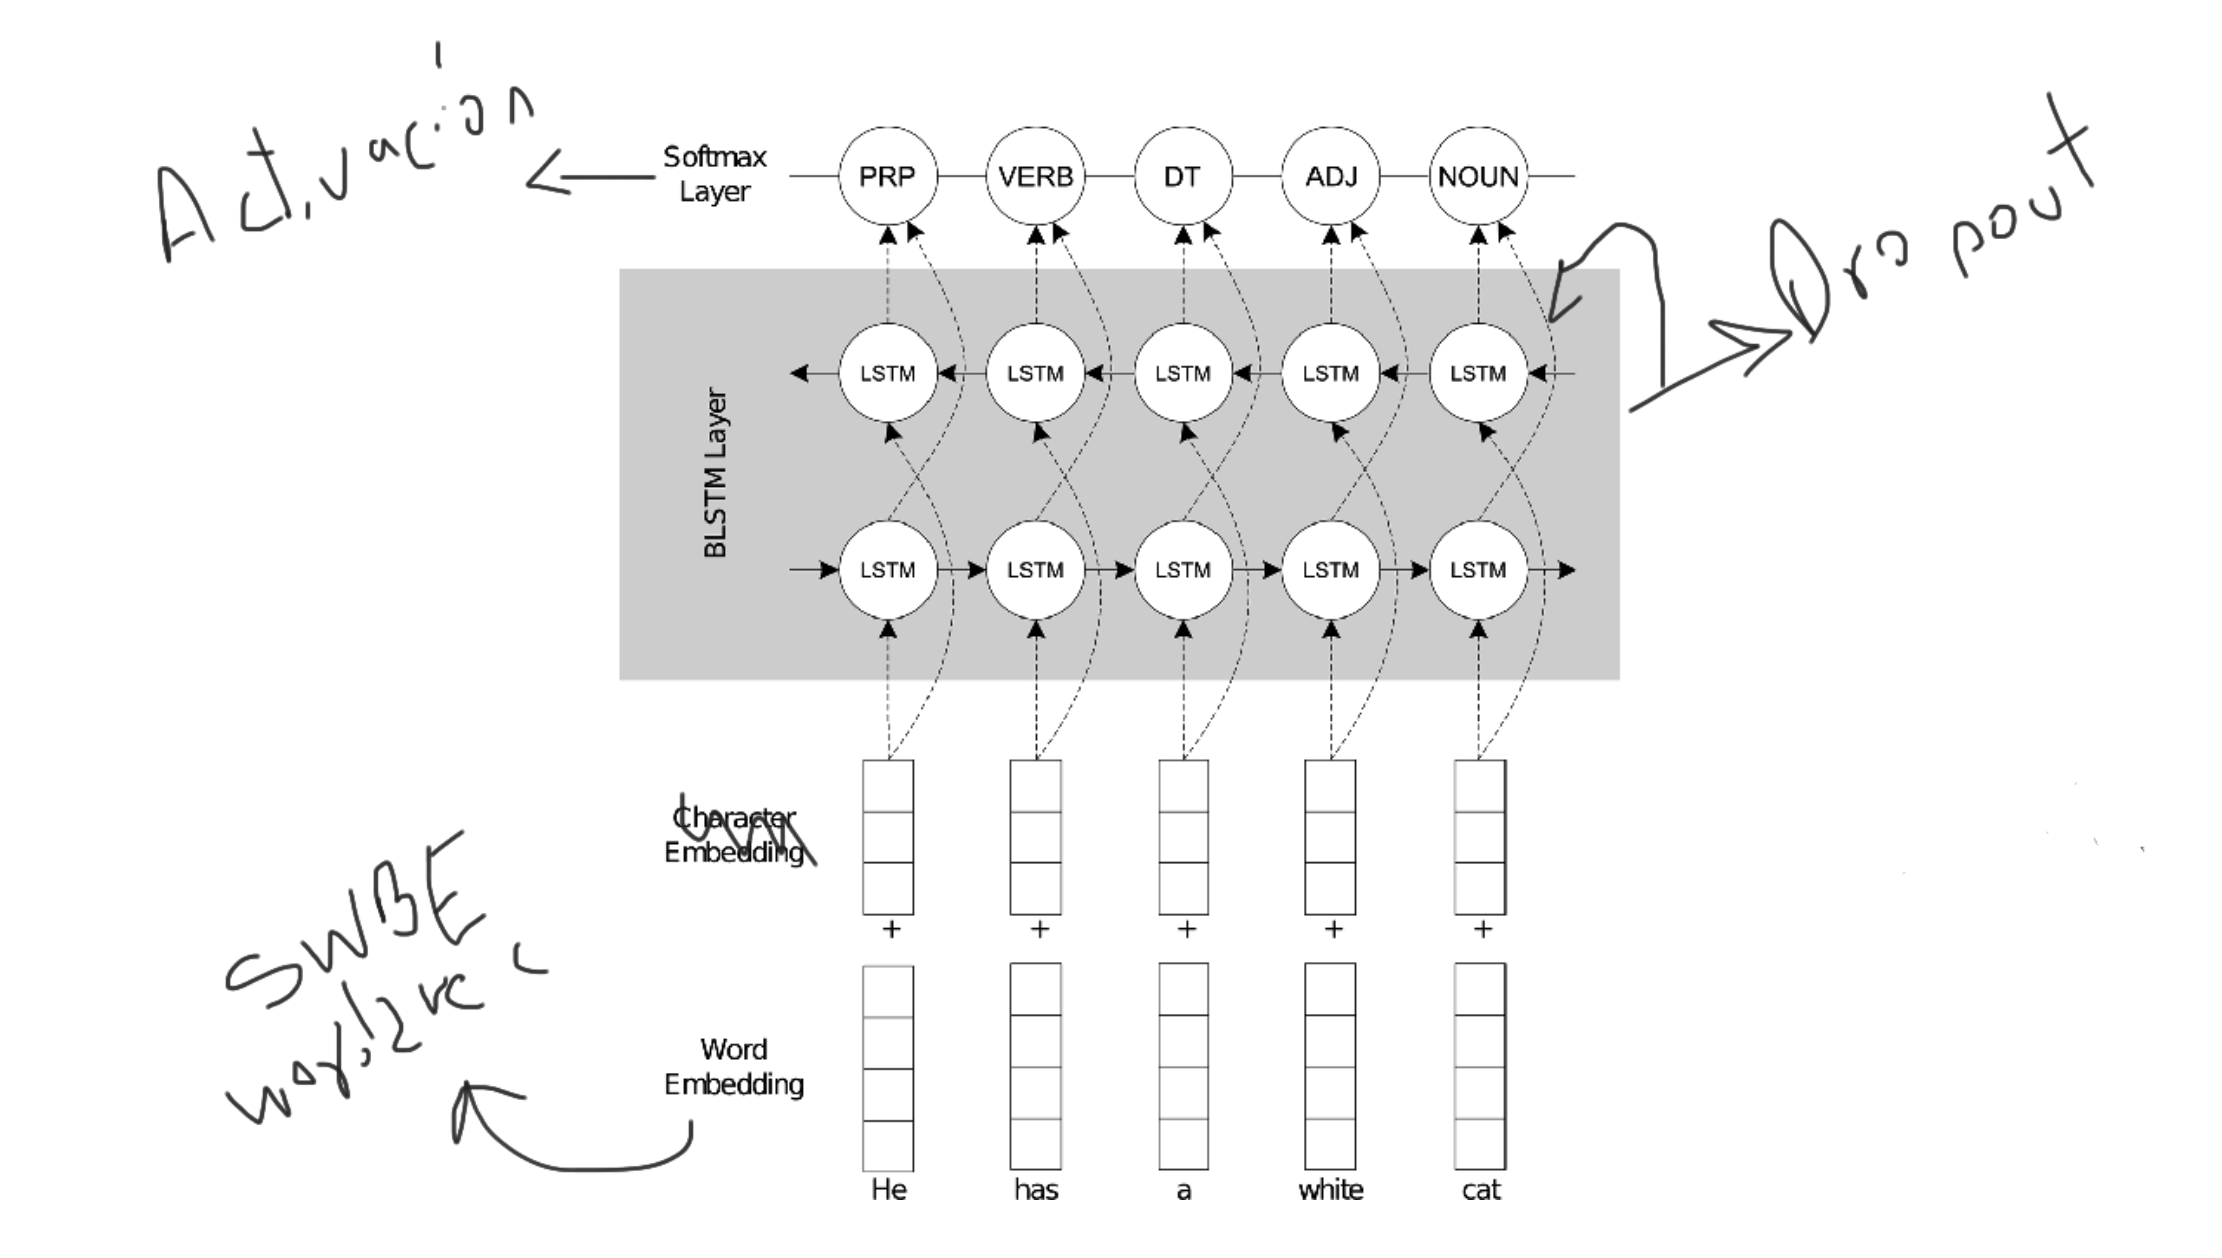

In [10]:
from IPython.display import Image
Image(filename='../Plot/blstm2.png')

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 149, 300)          7350000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 149, 600)          1442400   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 149, 291)          174891    
_________________________________________________________________
dropout_1 (Dropout)          (None, 149, 291)          0         
_________________________________________________________________
activation_1 (Activation)    (None, 149, 291)          0         
Total params: 8,967,291
Trainable params: 1,617,291
Non-trainable params: 7,350,000
_________________________________________________________________


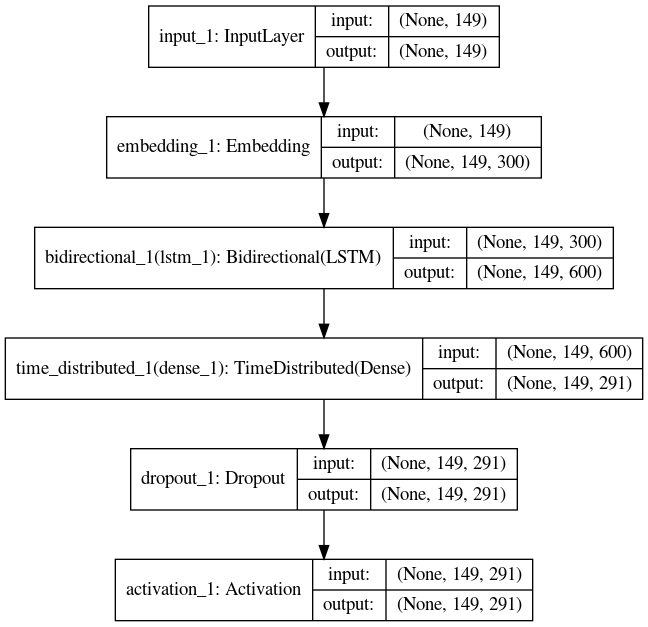

In [8]:
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Embedding, Activation, Bidirectional, LSTM, TimeDistributed, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import plot_model

lr = 0.001
lr_decay = 1e-4

embedding_layer = Embedding(len(word2index)+1, 300, weights=[embedding_matrix],  input_length=MAX_LENGTH, trainable=False)
#embedding_layer = Embedding(len(embeddings_index)+1, 300, weights=[embedding_matrix],  input_length=MAX_LENGTH, trainable=False)

model = Sequential()
model.add(InputLayer(input_shape=(MAX_LENGTH, )))
model.add(embedding_layer)
model.add(Bidirectional(LSTM(300, return_sequences=True)))
model.add(TimeDistributed(Dense(len(tag2index))))
model.add(Dropout(0.5))
model.add(Activation('softmax'))

optimizer = Adam(lr=lr, decay=lr_decay)

#parallel_model = multi_gpu_model(model, gpus=2)
#model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
 
model.summary()

plot_model(model, to_file='../Plot/model/model-mb09.png', show_shapes=True)

### Se dedarrolla el entrenamiento del modelo, el model.fit es el alimentador de la red, que tiene los ejemplos de entrenamiento y los ejemplos de validación para que funcione el gradiente y la precisión del modelo.

In [9]:
#sudo pip install h5py
import os
model_hist = model.fit(train_sentences_X, cat_train_tags_y,
                       validation_data=(eval_sentences_X, cat_eval_tags_y),
                       batch_size=128, 
                       epochs=40,
                       validation_split=0.1, verbose=1)

# serialize model to JSON
model_json = model.to_json()
with open("../model/mb-09.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("../model/mb-09.h5")
print("Saved model to disk")

Train on 3618 samples, validate on 1206 samples
Epoch 1/40
3618/3618 [==============================] - 15s 4ms/step - loss: 3.6555 - accuracy: 0.4890 - val_loss: 1.1610 - val_accuracy: 0.8155
Epoch 2/40
3618/3618 [==============================] - 10s 3ms/step - loss: 2.9767 - accuracy: 0.7178 - val_loss: 0.9102 - val_accuracy: 0.8459
Epoch 3/40
3618/3618 [==============================] - 10s 3ms/step - loss: 2.9101 - accuracy: 0.8133 - val_loss: 0.8003 - val_accuracy: 0.8675
Epoch 4/40
3618/3618 [==============================] - 10s 3ms/step - loss: 2.8609 - accuracy: 0.8281 - val_loss: 0.7297 - val_accuracy: 0.8872
Epoch 5/40
3618/3618 [==============================] - 10s 3ms/step - loss: 2.8160 - accuracy: 0.8378 - val_loss: 0.6582 - val_accuracy: 0.8965
Epoch 6/40
3618/3618 [==============================] - 10s 3ms/step - loss: 2.7917 - accuracy: 0.8431 - val_loss: 0.6089 - val_accuracy: 0.9006
Epoch 7/40
3618/3618 [==============================] - 11s 3ms/step - loss: 2.774

## PARTE 3  -  Evaluación del Modelo

### Evaluamos el modelo y calculamos el valor de precision con respecto a los datos de prueba

In [10]:
sess.close()

In [11]:
scores = model.evaluate(test_sentences_X, cat_test_tags_y)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")   # acc: 97.66269326210022

1206/1206 [==============================] - 5s 4ms/step
accuracy: 93.9647376537323


### Definimos la funcion que nos servira para graficar el comportamiento del modelo en cada epoca del entrenamiento

In [12]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')
    
    fig.savefig('../Plot/training/training-mb-09.png', bbox_inches='tight')

### Procedemos a Graficar el comportamiento del Entrenamiento, tanto del conjunto de entrenamiento como el de validación con respecto a la cantidad de epocas

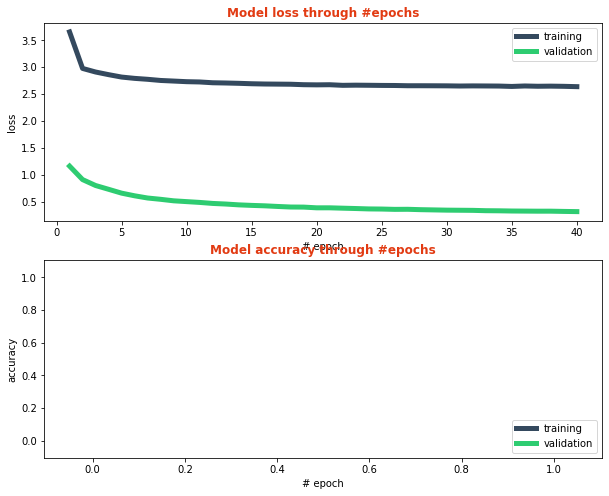

In [13]:
plot_model_performance(
    train_loss=model_hist.history.get('loss', []),
    train_acc=model_hist.history.get('acc', []),
    train_val_loss=model_hist.history.get('val_loss', []),
    train_val_acc=model_hist.history.get('val_acc', [])
)

### Función que Permite convertir Indices en Tags

In [14]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

### Hacemos la prediccion sobre el conjunto de pruebas 

In [15]:
import pandas as pd
print(test_sentences_X)
prediction = model.predict(test_sentences_X)
log_tokens = logits_to_tokens(prediction, {i: t for t, i in tag2index.items()})

print(log_tokens[0])

[[ 4050 24441  5495 ...     0     0     0]
 [ 5732 17490 15724 ...     0     0     0]
 [20828 23454 13685 ...     0     0     0]
 ...
 [ 7739 22222  2268 ...     0     0     0]
 [ 4050  6551 11929 ...     0     0     0]
 [ 3807  4050 16848 ...     0     0     0]]
['da0ms0', 'ncms000', 'vaip3s0', 'vaip3s0', 'vmp00sm', 'cs', 'da0fs0', 'ncfs000', 'sps00', 'dp3cs0', 'vaip3s0', 'vmp00sm', 'sps00', 'Fe', 'ncms000', 'Fe', 'Fc', 'cc', 'sn.e-SUJ', 'sn.e-SUJ', 'vmp00sm', 'cs', 'da0ms0', 'ncms000', 'sps00', 'da0ms0', 'ncms000', 'aq0ms0', 'cs', 'sps00', 'da0ms0', 'np0000l', 'Fe', 'di0mp0', 'vmip3s0', 'sps00', 'da0fs0', 'di0fs0', 'aq0fs0', 'Fe', 'Fp', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-

### Hallamos los valores de F1 score, recall, precision

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

results = pd.DataFrame(columns=['Expected', 'Predicted'])
k = 0
for i, lista_etiquetas_oracion in enumerate(test_tags):
    for j, etiquetas in enumerate(lista_etiquetas_oracion):
        k = k + 1
        results.loc[k, 'Expected'] = etiquetas
        results.loc[k, 'Predicted'] = log_tokens[i][j]

# print(results)


print('\nclassification_report:\n', classification_report(results['Expected'], results['Predicted']))

/home/deep-learning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/deep-learning/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



classification_report:
               precision    recall  f1-score   support

       -PAD-       0.00      0.00      0.00         0
         Faa       1.00      1.00      1.00         2
         Fat       0.75      0.60      0.67         5
          Fc       1.00      1.00      1.00      2291
          Fd       0.99      1.00      0.99        87
          Fe       1.00      0.98      0.99       631
          Fg       0.99      1.00      1.00       226
          Fh       0.00      0.00      0.00         3
         Fia       1.00      1.00      1.00         6
         Fit       0.95      1.00      0.97        19
          Fp       1.00      1.00      1.00      1178
         Fpa       0.99      1.00      1.00       156
         Fpt       0.75      0.79      0.77       160
          Fs       1.00      0.77      0.87        13
          Fx       1.00      1.00      1.00        41
          Fz       0.00      0.00      0.00         2
           W       0.56      0.14      0.22       194
  

In [17]:
#!pip install seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

print("F1-score: {:.1%}".format(f1_score(results['Expected'], results['Predicted'])))
print("precision-score: {:.1%}".format(precision_score(results['Expected'], results['Predicted'])))
print("recall-score: {:.1%}".format(recall_score(results['Expected'], results['Predicted'])))

F1-score: 71.1%
precision-score: 71.9%
recall-score: 70.4%


## PARTE 4  -  Testing

### Creamos un pequeño Ejemplo

In [18]:
test_samples = [
    "Correr es importante para mi .".split(),
    "El hombre bajo corre bajo el puente con bajo índice de adrenalina .".split()
]
print(test_samples)

[['Correr', 'es', 'importante', 'para', 'mi', '.'], ['El', 'hombre', 'bajo', 'corre', 'bajo', 'el', 'puente', 'con', 'bajo', 'índice', 'de', 'adrenalina', '.']]


### Convertimos el texto en Una entrada para el Modelo

In [20]:
from keras.preprocessing.sequence import pad_sequences

test_samples_X = []
for s in test_samples:
    s_int = []
    for w in s:
        try:
            s_int.append(word2index[w.lower()])
        except KeyError:
            s_int.append(word2index['-OOV-'])
    test_samples_X.append(s_int)

test_samples_X = pad_sequences(test_samples_X, maxlen=MAX_LENGTH, padding='post')
print(test_samples_X)

[[10010  8322  7887 14803 22085  6393     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [ 4050  4088  7396  3004  7396  4050  7704 10082  7396  4478 11847     1
   63

### Se Ejecuta la predicion con la Entrada del modelo entrenado

In [21]:
predictions = model.predict(test_samples_X)
print(predictions, predictions.shape)

[[[5.66908275e-05 4.92191699e-04 3.26496968e-03 ... 6.90442044e-04
   3.29151796e-03 1.82940473e-03]
  [1.18207834e-04 3.66635999e-04 2.87741469e-03 ... 5.10844076e-03
   6.29043533e-03 1.23225804e-03]
  [1.25066625e-04 2.50286917e-04 1.42529863e-03 ... 6.51509175e-03
   1.99303823e-03 6.74646231e-04]
  ...
  [9.99925256e-01 2.39308036e-07 2.81620629e-07 ... 2.13621576e-07
   1.33803027e-07 1.31074344e-07]
  [9.99923110e-01 2.45832553e-07 2.90109938e-07 ... 2.21737977e-07
   1.39158047e-07 1.35121738e-07]
  [9.99919772e-01 2.54293099e-07 3.00884409e-07 ... 2.31842293e-07
   1.46849814e-07 1.40398356e-07]]

 [[2.95485115e-05 1.20211262e-04 2.36437365e-04 ... 9.74811337e-05
   6.09489798e-05 8.50770302e-05]
  [5.13814623e-04 4.43165307e-04 2.04256061e-03 ... 2.22841161e-03
   2.28473265e-03 1.39860518e-03]
  [8.40974040e-04 2.56158208e-04 2.02226965e-03 ... 3.95379076e-03
   1.86365959e-03 1.00282731e-03]
  ...
  [9.99925256e-01 2.39308491e-07 2.81621169e-07 ... 2.13621789e-07
   1.33803

### Conversion de la Salida del Modelo a un lista de Indices de Tags

In [22]:
#print(len(predictions))
log_tokens = logits_to_tokens(predictions, {i: t for t, i in tag2index.items()})
print(log_tokens)

[['vmis3s0', 'sn.e-SUJ', 'rg', 'sps00', 'dp1css', 'Fp', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-',

### Presentación de los Resultados

In [23]:
#!pip install tabulate
from tabulate import tabulate

heads1 = test_samples[0]
body1 = [log_tokens[0][:len(test_samples[0])]]

heads2 = test_samples[1]
body2 = [log_tokens[1][:len(test_samples[1])]]

print(tabulate(body1, headers=heads1))

print ("\n")

print(tabulate(body2, headers=heads2))


## postagging Freeling 4.1

## El      hombre   bajo     corre    bajo  el      puente   con  bajo  índice   de  adrenalina  .
## DA0MS0  NCMS000  AQ0MS00  VMIP3S0  SP    DA0MS0  NCMS000  SP   SP    NCMS000  SP  NCFS000     Fp


## pos tagger Stanford NLP

## El      hombre   bajo     corre    bajo  el      puente   con    bajo   índice  de    adrenalina  .
## da0000  nc0s000  aq0000   vmip000  sp000 da0000  nc0s000  sp000  aq0000 nc0s000 sp000 nc0s000     fp

Correr    es        importante    para    mi      .
--------  --------  ------------  ------  ------  ---
vmis3s0   sn.e-SUJ  rg            sps00   dp1css  Fp


El      hombre    bajo    corre    bajo     el      puente    con    bajo    índice    de     adrenalina    .
------  --------  ------  -------  -------  ------  --------  -----  ------  --------  -----  ------------  ---
da0ms0  ncms000   aq0ms0  vmip3s0  vmn0000  da0ms0  ncms000   sps00  dp3cs0  ncfs000   sps00  ncms000       Fp
